In [1]:
import pandas as pd
# import glob
# from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import joblib
from tabulate import tabulate
import os

from package import my_modules
# # data science libraries
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold 
# from sklearn.impute import KNNImputer
# from sklearn.linear_model import LogisticRegression
# # from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.metrics import precision_recall_curve, auc
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import classification_report
# from sklearn.model_selection import cross_val_score
# from xgboost import XGBClassifier

In [2]:
rng = np.random.RandomState(42)

- Cell below is space to iteratively build functions for dataset prep, splitting

In [3]:

# # Get features and target variable
# dataset_A = load_data("../out_files/record_stats_outcome_merged.csv")
# dataset_A = prep_data(dataset_A) # currently this is just removing the RecordID column and composite scores

pipeline_steps = [my_modules.load_data, my_modules.prep_data]
dataset_A = my_modules.execute_pipeline("../out_files/record_stats_outcome_merged.csv", pipeline_steps)
# dataset_A.shape

Data loaded from ../out_files/record_stats_outcome_merged.csv
DataFrame Shape: (4000, 211)
Dataframe head
+----------+---------+---------+---------+---------+-------------+---------+---------------+-----------------+----------------+-------------+----------+---------+------------+-------------+----------+---------+--------+------------+-------------+-------+-------------+---------+--------------+--------+---------------+-----------+--------------+--------+-----------+----------+---------------+--------------+----------+------------+----------+---------------+---------------+-----------+---------+------------+--------+---------+---------+---------+---------+-------------+---------+---------------+-----------------+----------------+-------------+----------+---------+------------+-------------+----------+---------+--------+------------+-------------+-------+-------------+---------+--------------+--------+---------------+-----------+--------------+--------+-----------+----------+----------

In [4]:
# what is the baseline in hospital death rate (outcome variable)?
baseline_death_rate = dataset_A["In-hospital_death"].mean()
print(f"Baseline death rate: {baseline_death_rate:.2%}")

Baseline death rate: 13.85%


In [5]:
X, y = my_modules.get_X_y(dataset_A)
X_train, X_test, X_holdout, y_train, y_test, y_holdout = my_modules.get_train_test_holdout(X, y,random_state=rng)



Train, Test, Holdout Split Shapes:
X_train: (2400, 205), y_train: (2400,)
X_test: (800, 205), y_test: (800,)
X_holdout: (800, 205), y_holdout: (800,)

Target Variable Distribution:
y_train:
In-hospital_death
0    0.861667
1    0.138333
Name: proportion, dtype: float64
y_test:
In-hospital_death
0    0.86125
1    0.13875
Name: proportion, dtype: float64
y_holdout:
In-hospital_death
0    0.86125
1    0.13875
Name: proportion, dtype: float64

Full Dataset:
In-hospital_death
0    0.8615
1    0.1385
Name: proportion, dtype: float64


- Run eda on X_train, build data_clean function along the way for training
- Baseline model will built using logistic regression, so need to transform the dataset first to handle missing values
 

In [6]:
# X_train_cleaned = clean_data(X_train)
# X_train_cleaned.head()

for df in [X_train, X_test, X_holdout]:
    # get df name
    df_name = [name for name in globals() if globals()[name] is df][0]
    
    # apply clean_data function and create new DataFrame with suffix '_cleaned'
    cleaned_df_name = f"{df_name}_cleaned"
    cleaned_df = my_modules.clean_data(df)
    globals()[cleaned_df_name] = cleaned_df
    print(f"DataFrame Name: {df_name}\n shape: {df.shape}")
    print(f"Cleaned DataFrame Name: {cleaned_df_name} \n shape: {cleaned_df.shape}")
    my_modules.get_df_head_tail_shape(cleaned_df)
    
X_train_cleaned = X_train_cleaned.copy()
X_test_cleaned = X_test_cleaned.copy()
X_holdout_cleaned = X_holdout_cleaned.copy()
# X_train_cleaned.head()

DataFrame Name: X_train
 shape: (2400, 205)
Cleaned DataFrame Name: X_train_cleaned 
 shape: (2400, 184)

DataFrame Shape:
(2400, 184)

DataFrame Head:
+---------+---------+---------+-------------+---------+---------------+-----------------+----------------+-------------+----------+---------+-------------+----------+---------+--------+-------+-------------+---------+--------+---------------+-----------+--------------+--------+-----------+----------+---------------+--------------+----------+------------+----------+---------------+---------------+-----------+---------+--------+---------+---------+---------+-------------+---------+---------------+-----------------+----------------+-------------+----------+---------+-------------+----------+---------+--------+-------+-------------+---------+--------+---------------+-----------+--------------+--------+-----------+----------+---------------+--------------+----------+------------+----------+---------------+---------------+-----------+--------

In [7]:
# save the split datasets for baseline model 
joblib.dump((X_train_cleaned, X_test_cleaned, X_holdout_cleaned,y_train, y_test, y_holdout), "../out_files/cleaned_splits/split_data_cleaned.joblib")


['../out_files/cleaned_splits/split_data_cleaned.joblib']

In [8]:


# # ['median_ALP', 'median_ALT', 'median_AST', 'median_Age', 'median_Albumin', 'median_BUN', 'median_Bilirubin', 'median_Cholesterol', 'median_Creatinine', 'median_DiasABP', 'median_FiO2', 'median_GCS', 'median_Gender', 'median_Glucose', 'median_HCO3', 'median_HCT', 'median_HR', 'median_Height', 'median_ICUType', 'median_K', 'median_Lactate', 'median_MAP', 'median_MechVent', 'median_Mg', 'median_NIDiasABP', 'median_NIMAP', 'median_NISysABP', 'median_Na', 'median_PaCO2', 'median_PaO2', 'median_Platelets', 'median_RespRate', 'median_SaO2', 'median_SysABP', 'median_Temp', 'median_TroponinI', 'median_TroponinT', 'median_Urine', 'median_WBC', 'median_Weight', 'median_pH']


median_cols = my_modules.get_colnames_with_prefix(X_train_cleaned,'median_')
median_cols

# replace 'median_' with '' in the list median_cols
orginal_parameters = [col.replace('median_', '') for col in median_cols]
# print the list of original parameters
print(orginal_parameters)

['median_ALP',
 'median_ALT',
 'median_AST',
 'median_Albumin',
 'median_BUN',
 'median_Bilirubin',
 'median_Cholesterol',
 'median_Creatinine',
 'median_DiasABP',
 'median_FiO2',
 'median_GCS',
 'median_Glucose',
 'median_HCO3',
 'median_HCT',
 'median_HR',
 'median_K',
 'median_Lactate',
 'median_MAP',
 'median_Mg',
 'median_NIDiasABP',
 'median_NIMAP',
 'median_NISysABP',
 'median_Na',
 'median_PaCO2',
 'median_PaO2',
 'median_Platelets',
 'median_RespRate',
 'median_SaO2',
 'median_SysABP',
 'median_Temp',
 'median_TroponinI',
 'median_TroponinT',
 'median_Urine',
 'median_WBC',
 'median_pH']

['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Bilirubin', 'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR', 'K', 'Lactate', 'MAP', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'PaCO2', 'PaO2', 'Platelets', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'TroponinI', 'TroponinT', 'Urine', 'WBC', 'pH']


In [9]:
# # commenting to avoid rerunning the code
# # plot distributions of the ALL features and export to pdf file
# from matplotlib.backends.backend_pdf import PdfPages
# # Create a PDF file to save the plots
# pdf_file = "../out_files/parameter_distributions.pdf"
# with PdfPages(pdf_file) as pdf:
#     for paramater in orginal_parameters:
#         print(f"Parameter: {paramater}")
#         # Create a figure for the parameter
#         fig, axes = plt.subplots(2, 3, figsize=(14, 6), sharex=True)
#         axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array
#         for i, prefix in enumerate(['mean_', 'median_', 'std_','min_', 'max_']):
#             # Plot the distribution of the parameter with the prefix
#             sns.histplot(X_train[prefix + paramater], bins=30, kde=True, ax=axes[i])
#             axes[i].set_title(f"{prefix + paramater} Distribution")
#             axes[i].set_xlabel(prefix + paramater)
#             axes[i].set_ylabel("Frequency")
#         plt.tight_layout()
#         # Save the figure to the PDF
#         pdf.savefig(fig)
#         plt.close(fig)  # Close the figure to free up memory
# # Close the PDF file

In [10]:

# get list of columns that are not numeric
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-numeric columns:")

Non-numeric columns:


In [11]:
# # Commenting to prevent overwrite
# # subset medians from the splits and write it to a file for modeling
# non-stats cols list
icu_cols = my_modules.get_colnames_with_prefix(X_train_cleaned,'ICUType_')
non_stat_cols = ['MechVent', 'Age', 'Height','Weight'] + icu_cols

median_cols = my_modules.get_colnames_with_prefix(X_train_cleaned,'median_')

X_train_cleaned_median = X_train_cleaned[median_cols + non_stat_cols ]
X_test_cleaned_median = X_test_cleaned[median_cols + non_stat_cols ]
X_holdout_cleaned_median = X_holdout_cleaned[median_cols + non_stat_cols]


In [12]:
# write splits to file
joblib.dump((X_train_cleaned_median, X_test_cleaned_median, X_holdout_cleaned_median,y_train, y_test, y_holdout), "../out_files/cleaned_splits/split_data_cleaned_median.joblib")


['../out_files/cleaned_splits/split_data_cleaned_median.joblib']

In [13]:
my_modules.get_df_head_tail_shape(X_train_cleaned_median)
X_train_cleaned_median.columns


DataFrame Shape:
(2400, 43)

DataFrame Head:
+------------+------------+------------+----------------+------------+------------------+--------------------+-------------------+----------------+-------------+------------+----------------+-------------+--------------------+-----------+----------+----------------+------------+-----------+------------------+-------------------+-----------------+-----------+--------------+-------------+------------------+-----------------+-------------+---------------+-------------+------------------+------------------+--------------+------------+-----------+----------+------+--------+-------------------+-------------+-------------+-------------+-------------+
| median_ALP | median_ALT | median_AST | median_Albumin | median_BUN | median_Bilirubin | median_Cholesterol | median_Creatinine | median_DiasABP | median_FiO2 | median_GCS | median_Glucose | median_HCO3 |     median_HCT     | median_HR | median_K | median_Lactate | median_MAP | median_Mg | median_NID

Index(['median_ALP', 'median_ALT', 'median_AST', 'median_Albumin',
       'median_BUN', 'median_Bilirubin', 'median_Cholesterol',
       'median_Creatinine', 'median_DiasABP', 'median_FiO2', 'median_GCS',
       'median_Glucose', 'median_HCO3', 'median_HCT', 'median_HR', 'median_K',
       'median_Lactate', 'median_MAP', 'median_Mg', 'median_NIDiasABP',
       'median_NIMAP', 'median_NISysABP', 'median_Na', 'median_PaCO2',
       'median_PaO2', 'median_Platelets', 'median_RespRate', 'median_SaO2',
       'median_SysABP', 'median_Temp', 'median_TroponinI', 'median_TroponinT',
       'median_Urine', 'median_WBC', 'median_pH', 'MechVent', 'Age', 'Height',
       'Weight', 'ICUType_1.0', 'ICUType_2.0', 'ICUType_3.0', 'ICUType_4.0'],
      dtype='object')

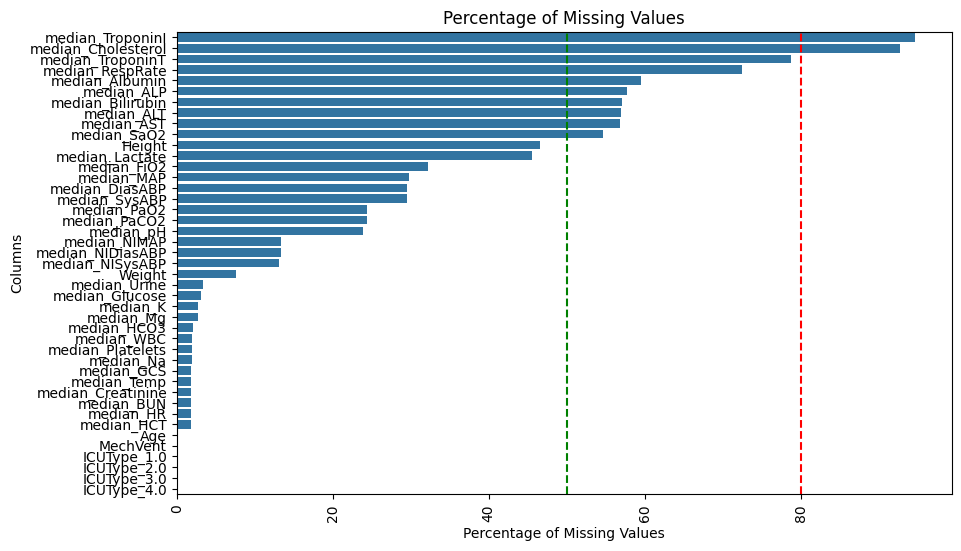

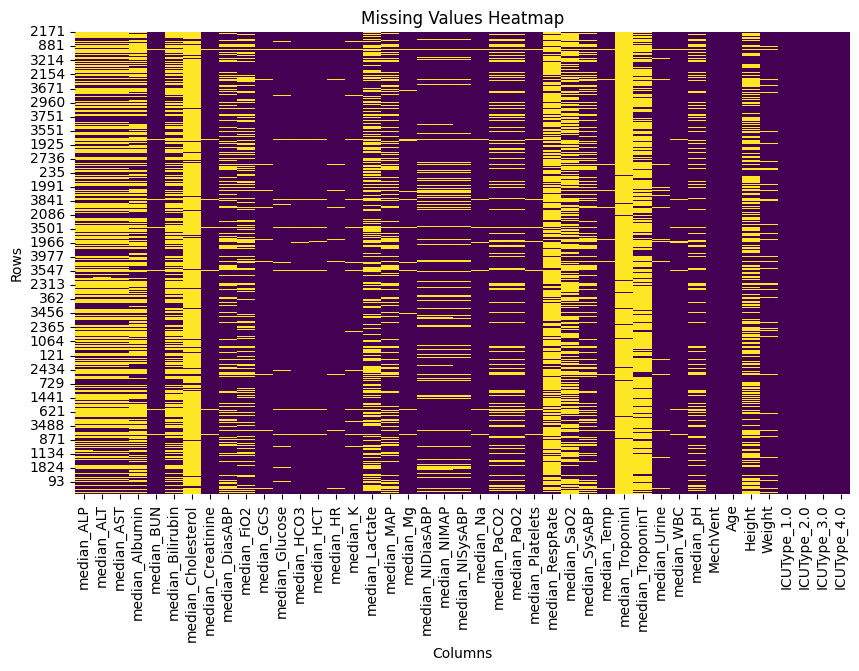

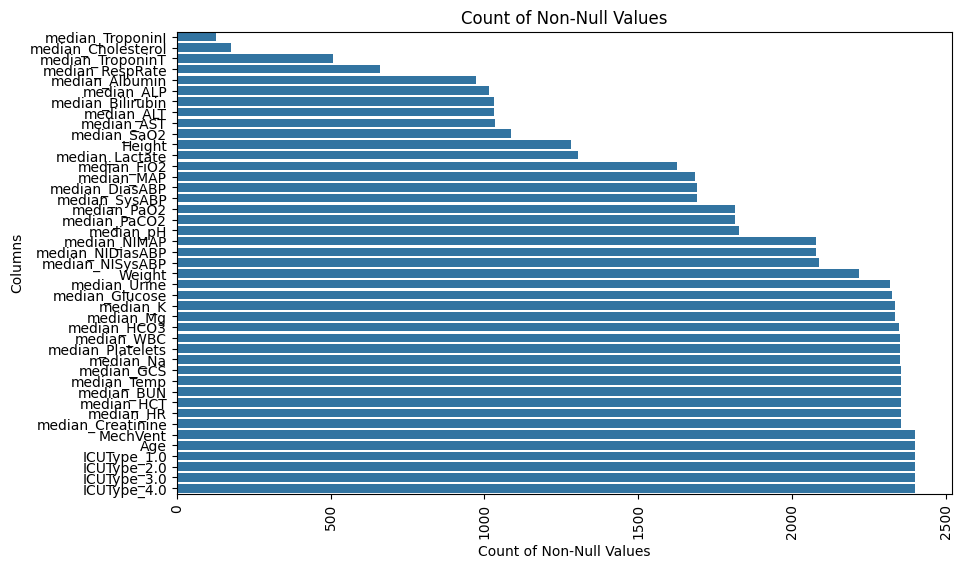

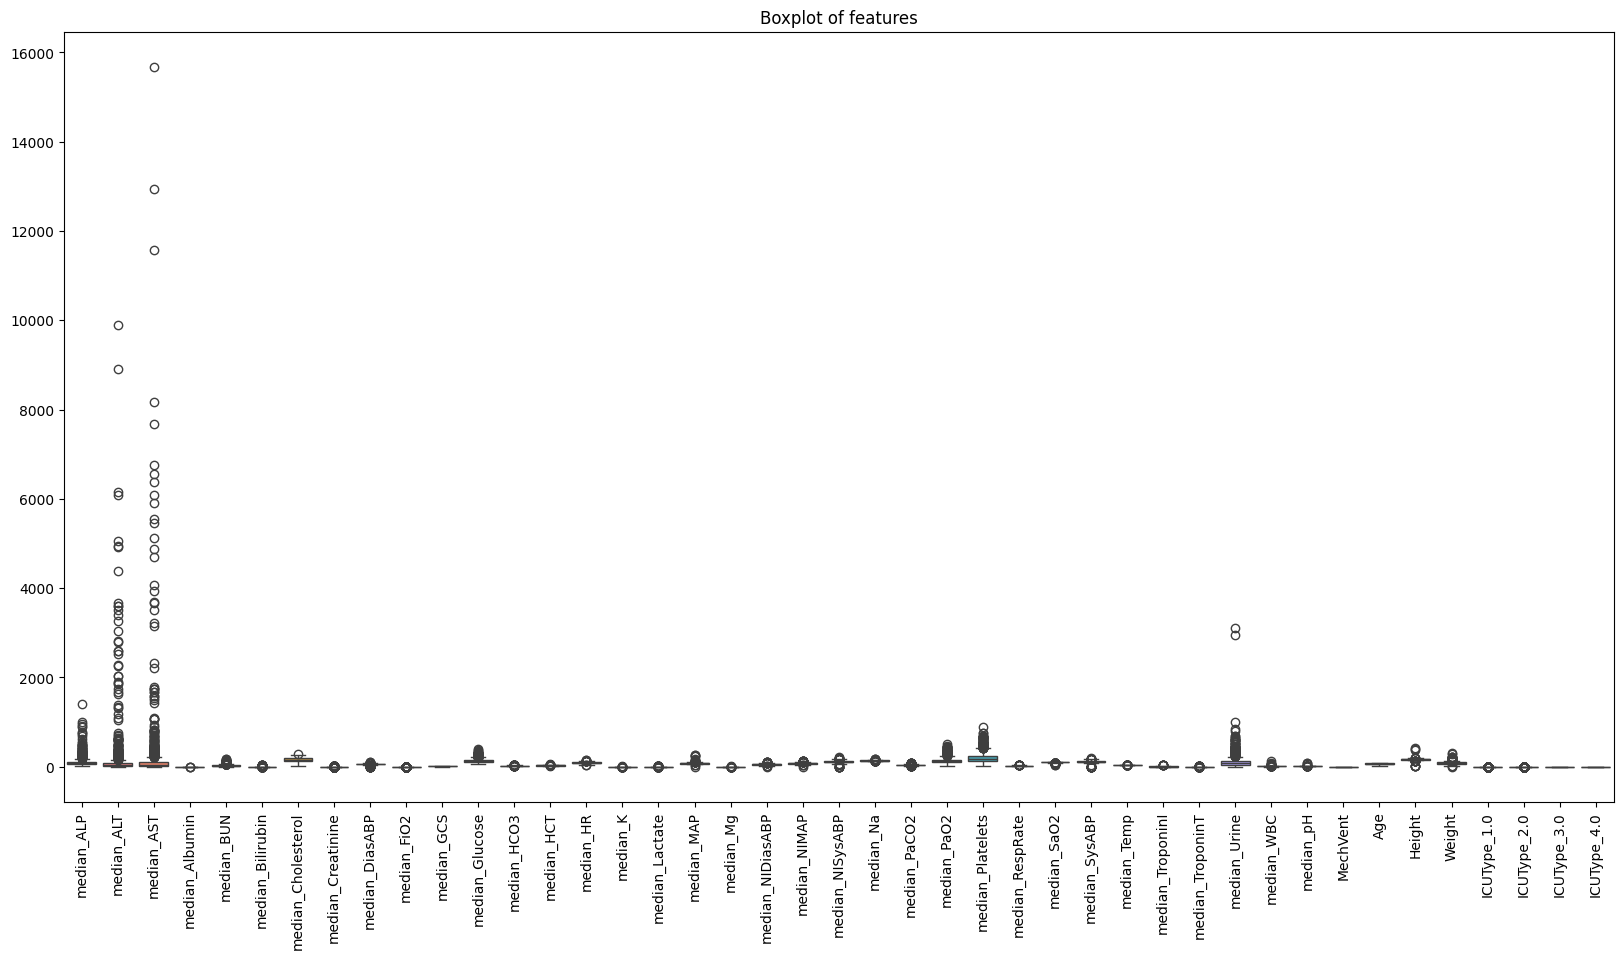

<Figure size 2000x1000 with 0 Axes>

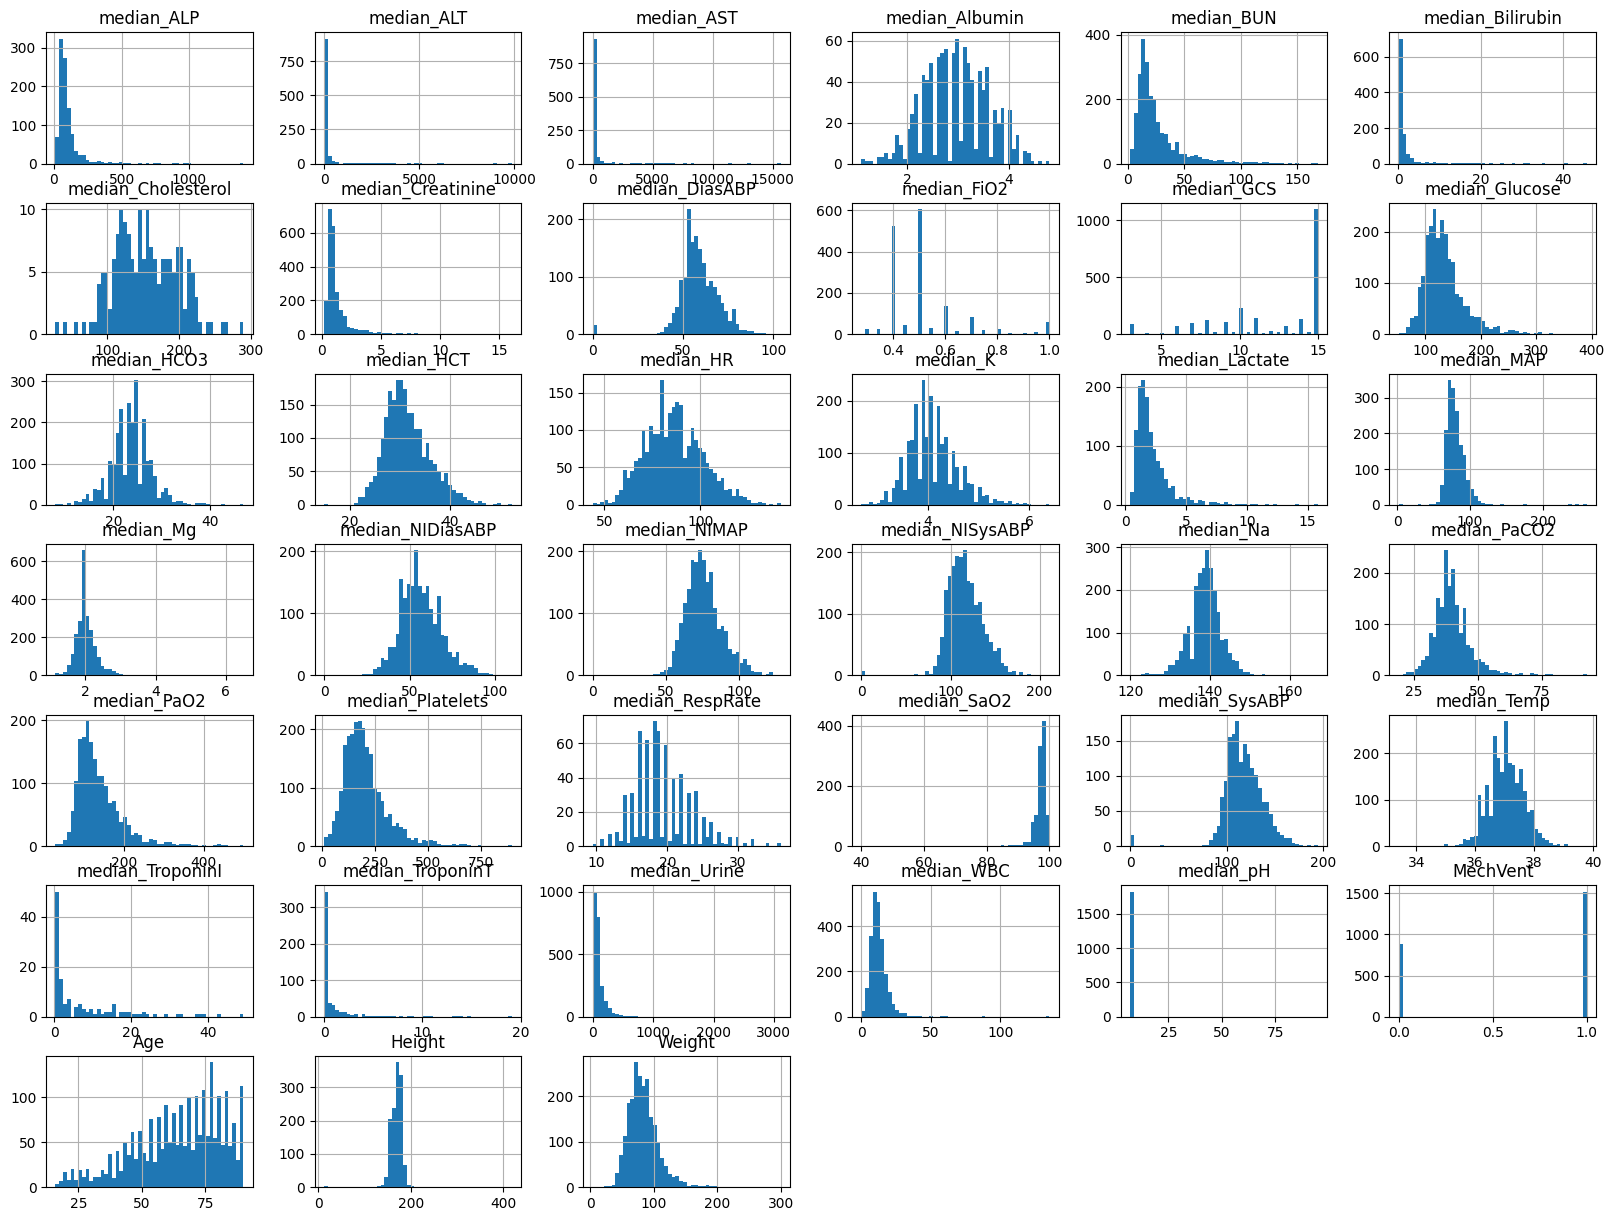

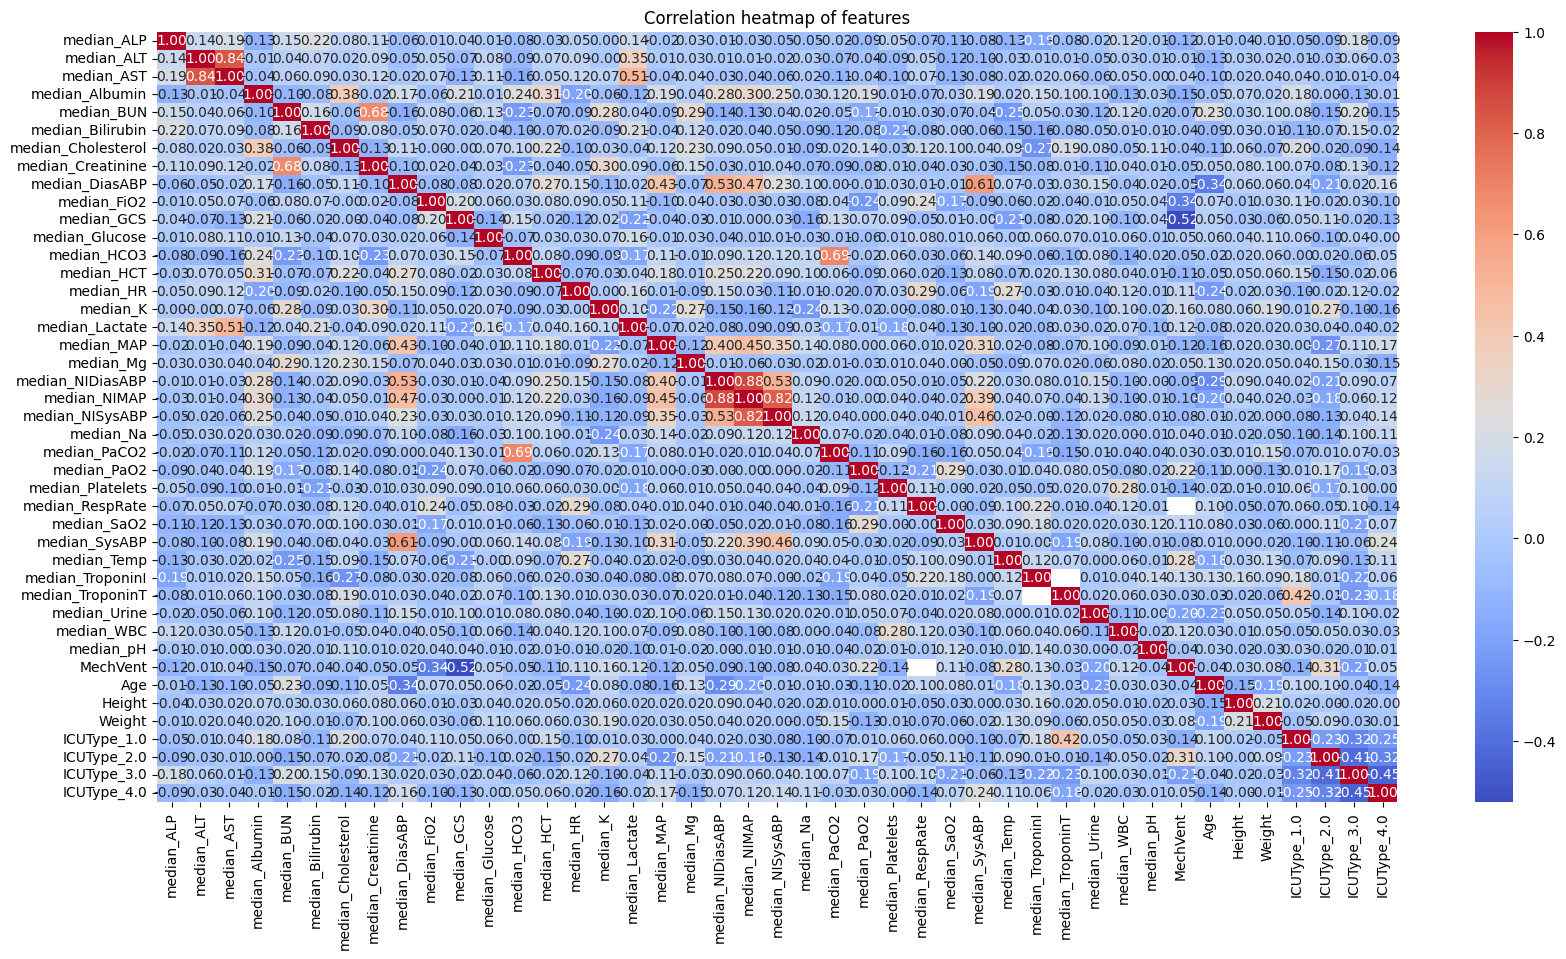

In [14]:
my_modules.eda_on_df(X_train_cleaned_median)

In [15]:
# there appear to be few highly correlated (>0.7) features
my_modules.print_highly_correlated(X_train_cleaned_median)

median_AST and median_ALT: 0.84
median_NIMAP and median_NIDiasABP: 0.88
median_NISysABP and median_NIMAP: 0.82


- X_train has 2400 patient entries, so with the estimate of ~14% in-hospital death we expect it to be ~33 when we do the train, test and holdout split 

- Ran 04_ML_median_features notebook using the above (median + general descriptor features)
    - models were build and tested using train and test respectively. Holdout is retained as-is for now
    - As expected, there was minimal improvement in the random forest models, but not much 
- Will do some feature engineering based on the EDA results (mostly empty features, highly correlated features)
    - TroponinI, Cholesterol & TroponinT have more than 80% null values, but are not highly correlated to any other features. Turning NaN to zeros (alternative approach would be to convert them to a presence absence to simplify the model)
    - For the highly correlated features, 
        - AST/ALT ratio - Based on sanity check below, will first replace NaN with 1 and then take the ratio (Biologically a ratio of 1 is not valid and can suggest acute viral hepatitis or hepatotoxicity)
        - drop NISysABP and NIDiasABP and retain just NIMAP
        - PaCO2/HC03 ratio - Based on sanity check below, will first replace NaN with 1 and then take the ratio

In [16]:
# sanity check
# X_test_cleaned_median.head()
# are there any rows where one is empty but the other is not? This is to avoid division by NaN issue
AST_ALT_nan = (X_test_cleaned_median['median_ALT'].isna()& ~(X_test_cleaned_median['median_AST'].isna()))
(X_test_cleaned_median[AST_ALT_nan]).shape[0] 

Pa_HC_nan = (X_test_cleaned_median['median_PaCO2'].isna()& ~(X_test_cleaned_median['median_HCO3'].isna()))
(X_test_cleaned_median[Pa_HC_nan]).shape[0] 

# based on this, a better approach would be to replace NaN with 1's before taking a ratio 

# 

1

172

In [17]:
selected_columns = ['median_AST', 'median_ALT', 'median_PaCO2', 'median_HCO3','median_TroponinI','median_Cholesterol','median_TroponinT']
X_test_cleaned_median[selected_columns].describe()
# do any have value 1 ? i.e. will we nullify those by transforming NaN to 1?

X_test_cleaned_median.query('median_AST == 1 or median_ALT == 1 or median_PaCO2 == 1 or median_HCO3 == 1')


,median_AST,median_ALT,median_PaCO2,median_HCO3,median_TroponinI,median_Cholesterol,median_TroponinT
count,352.000000,352.000000,620.000000,782.000000,42.000000,67.000000,173.000000
mean,201.829545,153.552557,40.059677,23.684783,7.428571,160.261194,1.186474
std,663.966305,580.041499,8.475165,4.259440,10.338114,51.568824,2.897092
min,6.500000,3.000000,14.000000,9.000000,0.600000,73.000000,0.010000
25%,24.000000,17.000000,35.500000,21.000000,1.100000,133.000000,0.050000
50%,42.000000,30.000000,39.000000,24.000000,2.250000,154.000000,0.135000
75%,81.000000,60.000000,43.000000,26.000000,7.950000,185.000000,0.630000
max,6241.000000,6391.500000,99.000000,44.000000,40.100000,330.000000,20.000000


,median_ALP,median_ALT,median_AST,median_Albumin,median_BUN,median_Bilirubin,median_Cholesterol,median_Creatinine,median_DiasABP,median_FiO2,...,median_WBC,median_pH,MechVent,Age,Height,Weight,ICUType_1.0,ICUType_2.0,ICUType_3.0,ICUType_4.0


- Next iteration of Feature engineering & ML in `05_FeatureEngineering_ML`